In [2]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.cluster import KMeans
from geopy.geocoders import Nominatim, Photon
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import numpy as np
import ast
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
from tabulate import tabulate
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from warnings import simplefilter
from matplotlib.ticker import FuncFormatter
import xgboost as xgb
from scipy import stats
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import shap
import math
from sklearn.model_selection import RandomizedSearchCV, KFold
from xgboost import XGBRegressor
from scipy.stats import randint, uniform
from sklearn.metrics import make_scorer

# Initial preprocessing
Making sure that the entire dataset is clean and ready to be used.

In [3]:
data = pd.read_excel("Homestays_Data.xlsx")
print(data.columns.values)

['id' 'log_price' 'property_type' 'room_type' 'amenities' 'accommodates'
 'bathrooms' 'bed_type' 'cancellation_policy' 'cleaning_fee' 'city'
 'description' 'first_review' 'host_has_profile_pic'
 'host_identity_verified' 'host_response_rate' 'host_since'
 'instant_bookable' 'last_review' 'latitude' 'longitude' 'name'
 'neighbourhood' 'number_of_reviews' 'review_scores_rating'
 'thumbnail_url' 'zipcode' 'bedrooms' 'beds']


## Ordinal Encoding

In [4]:
def ordinal_encode(col, vals, target_vals):
    d = dict(zip(vals, target_vals))
    for val in vals:
        data.loc[data[col]==val, col] = d[val]

data = data.map(lambda x: 1 if x == True else x)
data = data.map(lambda x: 0 if x == False else x)
ordinal_encode("host_has_profile_pic", ["t","f"], [1,0])
ordinal_encode("host_identity_verified", ["t","f"], [1,0])
ordinal_encode("instant_bookable", ["t","f"], [1,0])
ordinal_encode("cancellation_policy", ['super_strict_60', 'super_strict_30', 'strict', 'moderate', 'flexible'], [4,3,2,1,0])

## Dealing with missing values
Will decide the best course of action for dropping NA values (whether to drop rows or features) after judging each feature's importance in later sections.

In [5]:
print("Number of rows with NaN values: ", data.isna().any(axis=1).sum())
print("Cols vs number of NaN values:\n", tabulate(pd.DataFrame(data.isna().sum()[data.isna().sum()!=0].sort_values(ascending = False), columns=["NaN count"]), headers='keys', tablefmt='psql'))

Number of rows with NaN values:  35615
Cols vs number of NaN values:
 +------------------------+-------------+
|                        |   NaN count |
|------------------------+-------------|
| host_response_rate     |       18299 |
| review_scores_rating   |       16722 |
| first_review           |       15864 |
| last_review            |       15827 |
| thumbnail_url          |        8216 |
| neighbourhood          |        6872 |
| zipcode                |         966 |
| bathrooms              |         200 |
| host_since             |         188 |
| host_has_profile_pic   |         188 |
| host_identity_verified |         188 |
| beds                   |         131 |
| bedrooms               |          91 |
| name                   |          10 |
| description            |           6 |
+------------------------+-------------+


# 1. Feature Engineering:
Task: Enhance the dataset by creating actionable and insightful features. Calculate `Host_Tenure` by
determining the number of years from `host_since` to the current date, providing a measure of host
experience. Generate `Amenities_Count` by counting the items listed in the `amenities` array to quantify
property offerings. Determine `Days_Since_Last_Review` by calculating the days between `last_review`
and today to assess listing activity and relevance.

## Adding host tenure, days since first and last reviews and amenity count

In [6]:
data["host_since"] = pd.to_datetime(data["host_since"], format='%Y-%m-%d')
data["last_review"] = pd.to_datetime(data["host_since"], format='%Y-%m-%d')
current_date = datetime.now()

data['Host_Tenure'] = (current_date - data["host_since"]).dt.days / 365.25
data["Days_Since_Last_Review"] = (current_date - data["last_review"]).dt.days
data["Days_Since_First_Review"] = (current_date - data["first_review"]).dt.days

def count_elements(string):
    return len(string[1:-1].split(","))
data["Amenities_Count"] = data["amenities"].apply(count_elements)



## Adding distance from city centre
We will explore this feature in the Geospatial Analysis section.

In [7]:
city_coordinates = {
    'LA': [34.052235, -118.243683],
    'Boston': [42.3601, -71.0589],
    'Chicago': [41.8781, -87.6298],
    'NYC': [40.7128, -74.0060],
    'DC': [38.9072, -77.0369],
    'SF': [37.7749, -122.4194]
}

data["city_centre_distance"] = np.nan

def get_distance(row):
    city = row["city"]    
    centre = city_coordinates[city]
    distance = math.sqrt(((row["latitude"]-centre[0])**2)+((row["longitude"]-centre[1])**2))
    row["city_centre_distance"] = distance
    return row

data = data.apply(get_distance, axis=1)

## Displaying newly engineered features

In [8]:
data[["Host_Tenure", "Amenities_Count", "Days_Since_Last_Review", "Days_Since_First_Review", "city_centre_distance"]]

Host_Tenure  Amenities_Count  Days_Since_Last_Review  \
0        12.114990                9                  4425.0   
1         6.882957               15                  2514.0   
2         7.531828               19                  2751.0   
3         9.051335               15                  3306.0   
4         9.185489               12                  3355.0   
...            ...              ...                     ...   
74106    11.121150                1                  4062.0   
74107     8.010951               16                  2926.0   
74108    12.336756               31                  4506.0   
74109     6.636550               15                  2424.0   
74110    11.444216               18                  4180.0   

       Days_Since_First_Review  city_centre_distance  
0                       2880.0              0.021721  
1                       2467.0              0.055948  
2                       2564.0              0.113835  
3                          NaN              0.012557  
4                       3283.0              0.018570  
...                        ...                   ...  
74106                      NaN              0.066702  
74107                   2822.0              0.236356  
74108                   3412.0              0.063910  
74109                      NaN              0.026390  
74110                   3897.0              0.295619  

[74111 rows x 5 columns]

# 2. Exploratory Data Analysis (EDA):
Task: Conduct a deep dive into the dataset to uncover underlying patterns and relationships. Analyze how
pricing (`log_price`) correlates with both categorical (such as `room_type` and `property_type`) and
numerical features (like `accommodates` and `number_of_reviews`). Utilize statistical tools and
visualizations such as correlation matrices, histograms for distribution analysis, and scatter plots to explore
relationships between variables.

## Getting correlation heatmap
From the heatmap below, we can observe the following - 
1. log_price is highly correlated with accommodates, bedrooms, beds, bathrooms, amenities_count, cancellation_policy and cleaning_fee
2. bedrooms, beds, bathrooms and accommodations are highly correlated with each other
3. days_since_first_review, days_since_last_review and Host Tenure are highly correlated with each other

In [9]:
corrtargets = ["log_price", "accommodates", "bathrooms", "cancellation_policy", "cleaning_fee", "host_has_profile_pic", "host_identity_verified", "host_response_rate", "instant_bookable", "number_of_reviews", "bedrooms", "beds", "Host_Tenure", "Days_Since_Last_Review", "Amenities_Count", "Days_Since_First_Review", "review_scores_rating"]

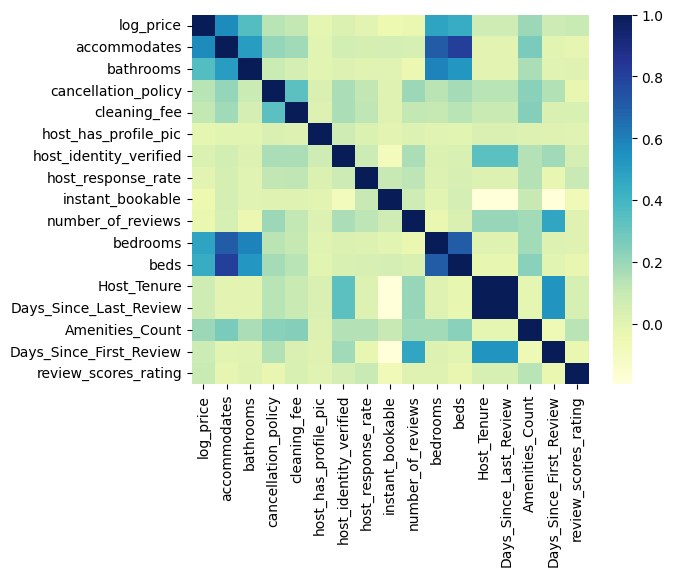

In [10]:
correlation_matrix = data[corrtargets].corr()
corrheatmap = sb.heatmap(pd.DataFrame(correlation_matrix), cmap="YlGnBu") 

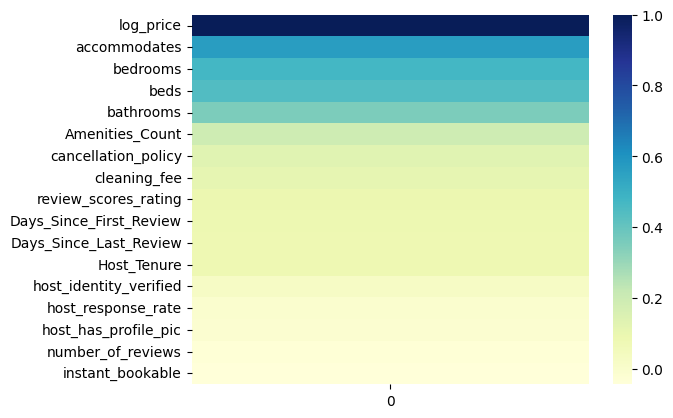

In [11]:
correlation_matrix2 = data[corrtargets].corrwith(data["log_price"])
correlation_matrix2.sort_values(axis = 0, ascending = False, inplace = True)
# print(tabulate(pd.DataFrame(correlation_matrix2, columns=["Correlation with log_price"]), headers='keys', tablefmt='psql'))
corrheatmap2 = sb.heatmap(pd.DataFrame(correlation_matrix2), cmap="YlGnBu") 

## Getting histograms

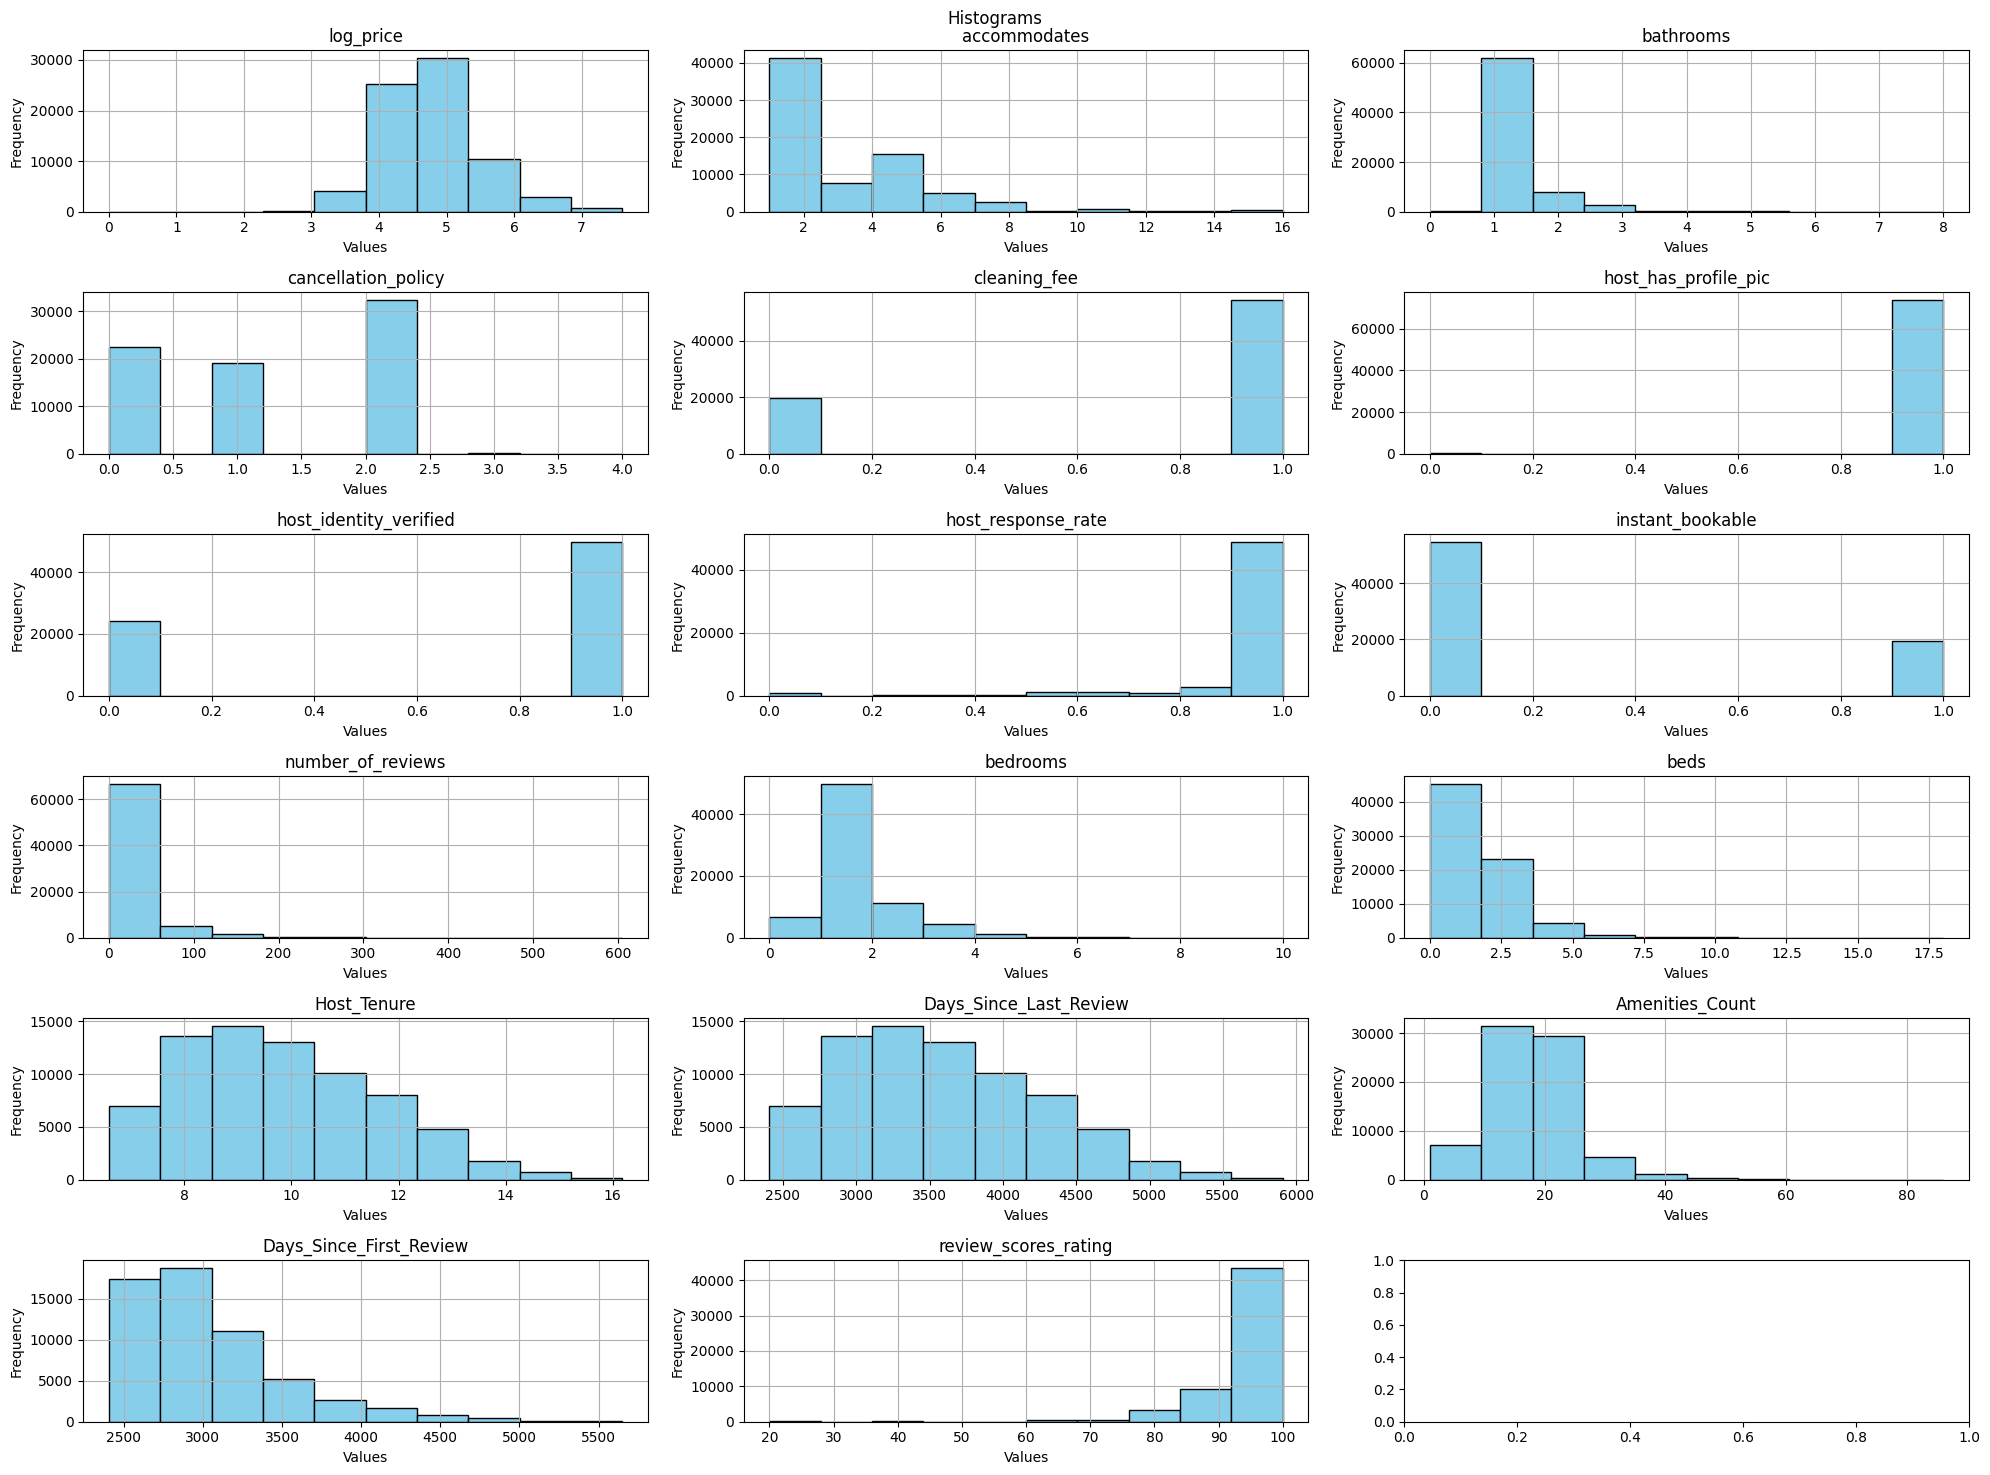

In [12]:
# Histograms
fig, ax = plt.subplots(len(corrtargets)//3 + 1,3, figsize = (20,15))
i = 0
# for col in list(data.columns.values):
for col in corrtargets:
    # Plot the histogram
    try:
        data[col].hist(color='skyblue', edgecolor='black', ax = ax.flatten()[i])
        ax.flatten()[i].set_title(f"{col}")
        ax.flatten()[i].set_xlabel('Values')
        ax.flatten()[i].set_ylabel('Frequency')
        i = i + 1
    except:
        continue

fig.suptitle("Histograms")
plt.tight_layout()

We can observe the following from the above histograms - 
1. Prices tend to be concentrated in 10^4 to 10^6 USD
2. Most homestays have only 2 accommodations
3. Most homestays have only 1 bathroom
4. Most homestays charge a cleaning fee
5. Most hosts have a profile picture
6. Most hosts identities have been verified
7. Host response rate is mostly 100%
8. More homestays are instantly bookable than not
9. Most homestays have less than 100 reviews
10. Most homestays have 1-2 bedrooms and beds
11. Most hosts have had a tenure of 8-12 years
12. Most homestays have around 10-20 amenities
13. Most homestays have reviews above 80%

## Getting scatter plots

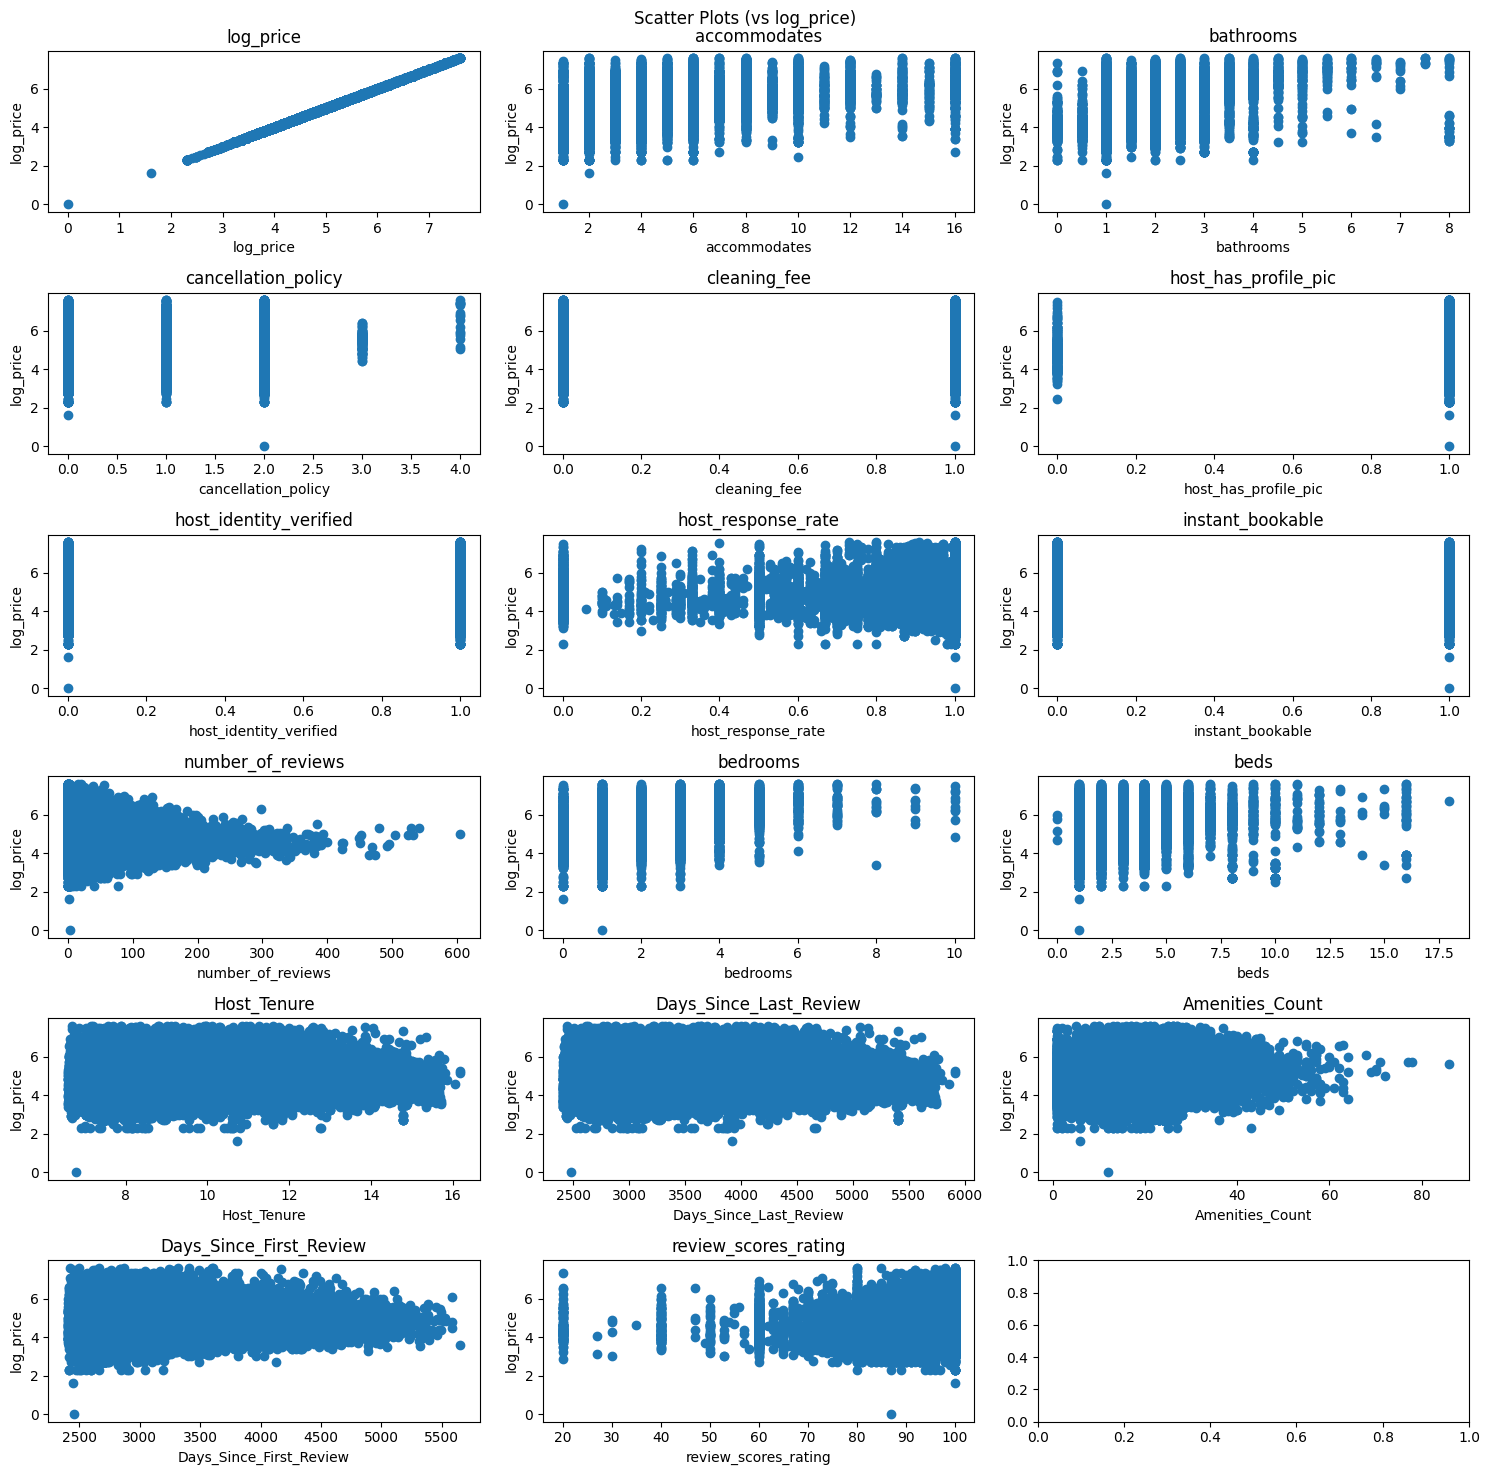

In [13]:
# Scatter plot
fig, ax = plt.subplots(len(corrtargets)//3 + 1,3, figsize = (15,15))
i = 0
for col in corrtargets:
    ax.flatten()[i].scatter(data[col], data["log_price"])
    ax.flatten()[i].set_title(f"{col}")
    ax.flatten()[i].set_xlabel(col)
    ax.flatten()[i].set_ylabel("log_price")
    i = i + 1

fig.suptitle("Scatter Plots (vs log_price)")
plt.tight_layout()

We can observe the following from the above scatter plots - 
1. Lesser priced homestays tend to have more reviews
2. Higher priced homestays tend to have higher reviews
3. Very low priced homestays have lesser amenities
4. Many features do not seem to share a considerable relation with log_price

# 3. Geospatial Analysis:
Task: Investigate the geographical data to understand regional pricing trends. Plot listings on a map using
`latitude` and `longitude` data to visually assess price distribution. Examine if certain neighbourhoods or
proximity to city centres influence pricing, providing a spatial perspective to the pricing strategy.

In [ ]:
scaler = MinMaxScaler()
fig = px.scatter_mapbox(data, 
                        lat="latitude", 
                        lon="longitude", 
                        hover_name="id", 
                        hover_data=["id", "neighbourhood"],
                        color= scaler.fit_transform(np.array(data["log_price"]).reshape(-1, 1)).flatten(),
                        color_continuous_scale="inferno",
                        # size="Listed",
                        zoom=3, 
                        height=800,
                        width=800)

scatter_data = {
    "lat": [34.052235, 42.360081, 40.712776, 41.878113, 38.907192, 37.774929],
    "lon": [-118.243683, -71.058884, -74.005974, -87.629799, -77.036871, -122.419416],
    "text": ["Los Angeles", "Boston", "New York City", "Chicago", "Washington D.C.", "San Francisco"],
    "size": [1] * 6,  # Size of the markers
    "color": ["blue"] * 6  # Color of the markers
}

fig.add_trace(px.scatter_mapbox(**scatter_data).data[0])

fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

Brighter spots have higher prices. Dark red spots have lower prices. Big blue markers represent city centres. We can observe the following trends - 
1. Price decreases with distance from city centre (Will be quantitatively examined later in this section)
2. Price increases along coastlines
3. Price is higher in some cities than others (Will be quantitatively examined later in this section)
#### Chicago
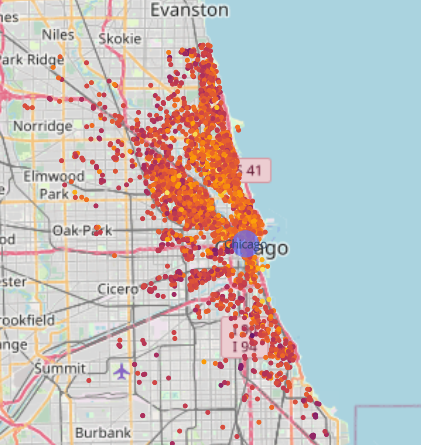
#### Washington DC
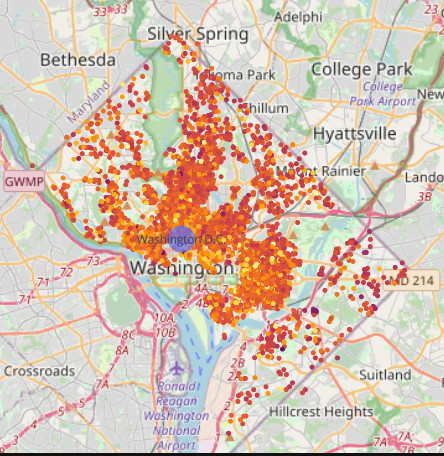
#### New York City
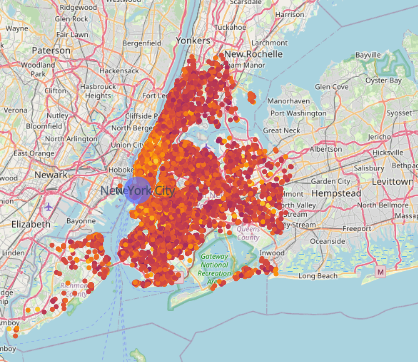
#### Los Angeles
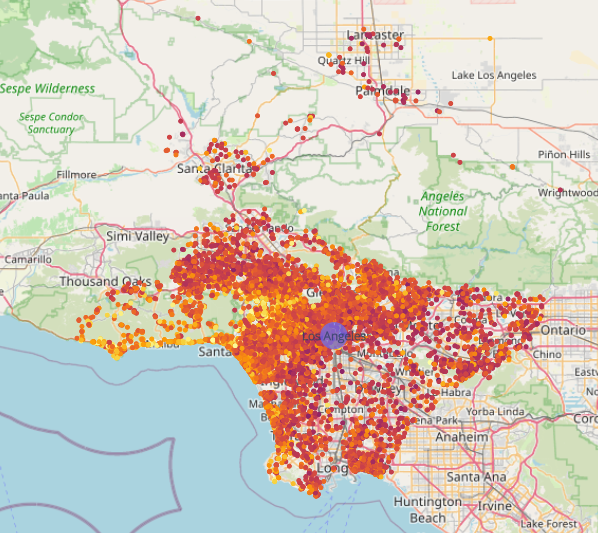
#### San Francisco
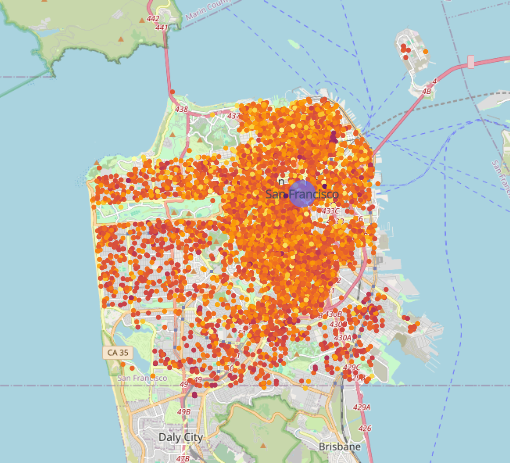

In [15]:
print("Correlation of city centre distance with log_price:", data[["city_centre_distance"]].corrwith(data["log_price"])["city_centre_distance"])


Correlation of city centre distance with log_price: -0.128331090593968


Thus, we can see that as we move away from the centre of the city, prices decrease. This makes sense logically as well.

## Neighbourhood price distribution

619 neighbourhoods


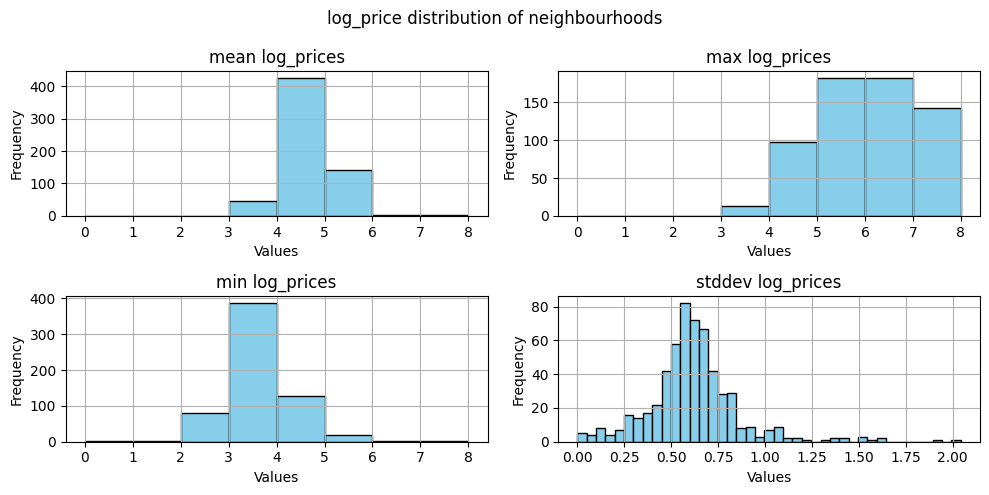

In [16]:
print(len(list(pd.get_dummies(data["neighbourhood"]).columns.values)), "neighbourhoods")

# Calculate stats for log price for each neighbourhood
neighbourhood_prices = pd.DataFrame(columns = ["neighbourhood", "mean log_price", "max log_price", "min log_price", "stddev log_price", "mean latitude", "mean longitude"])
i = 0
for neighbourhood in data["neighbourhood"].unique():
    slice = data[data["neighbourhood"] == neighbourhood]
    neighbourhood_prices.loc[i] = [neighbourhood, slice["log_price"].mean(), slice["log_price"].max(), slice["log_price"].min(), slice["log_price"].std(), slice["latitude"].mean(), slice["longitude"].mean()]
    i = i+1

neighbourhood_prices = neighbourhood_prices.sort_values(by="mean log_price", ascending = False)
tabulate(neighbourhood_prices, headers='keys', tablefmt='psql')

fig, ax = plt.subplots(2,2, figsize = (10,5))

i = 0
for col in list(neighbourhood_prices.columns.values):
    if col[-len("log_price"):] == "log_price":
        if col != "stddev log_price":
            bins = [0,1,2,3,4,5,6,7,8]
        else:
            bins = "auto"
        neighbourhood_prices[col].hist(bins = bins, color='skyblue', edgecolor='black', ax = ax.flatten()[i])
        ax.flatten()[i].set_title(f"{col}s")
        ax.flatten()[i].set_xlabel('Values')
        if col != "stddev log_price":
            ax.flatten()[i].set_xticks(ticks = bins, labels = bins)
        ax.flatten()[i].set_ylabel('Frequency')
        i = i + 1
    
fig.suptitle('log_price distribution of neighbourhoods')
plt.tight_layout()

Thus, we observe that neighbourhoods do influence prices. Several neighbourhoods mean and max prices are much higher than others. Let us now look at the correlations between specific neighbourhoods with higher or lower prices.

## Neighbourhood correlation heatmaps

In [17]:
# One hot encoding neighbourhoods
neighbourhood_list = list(pd.get_dummies(data["neighbourhood"]).columns.values)
one_hot = pd.get_dummies(data["neighbourhood"])
# data = data.drop("neighbourhood",axis = 1)
data = pd.concat([data, one_hot], axis = 1)

In [18]:
correlation = data[neighbourhood_list].corrwith(data["log_price"])
correlation = correlation.sort_values(ascending = False)

### Neighbourhoods associated with higher prices
From the below heatmap, we can observe that neighbourhoods such as Malibu, West Village, Capitol Hill etc(given below), have much higher prices than other neighbourhoods.

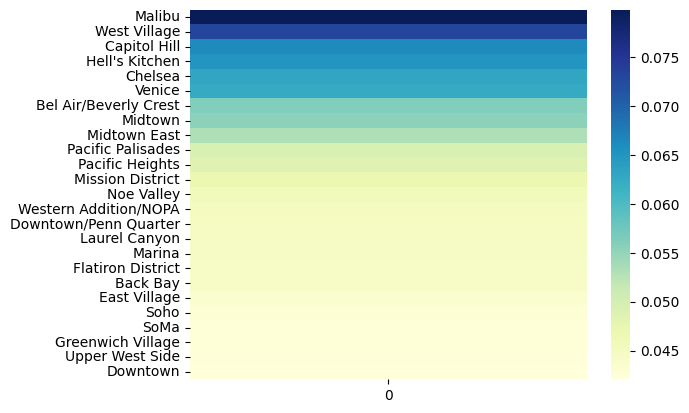

In [19]:
corrheatmap = sb.heatmap(pd.DataFrame(correlation).head(25), cmap="YlGnBu") 

### Neighbourhoods associated with lower prices
From the below heatmap, we can observe that neighbourhoods such as East Flatbush, Flushing, Dorchester etc(given below), tend to have much cheaper prices than other neighbourhoods.

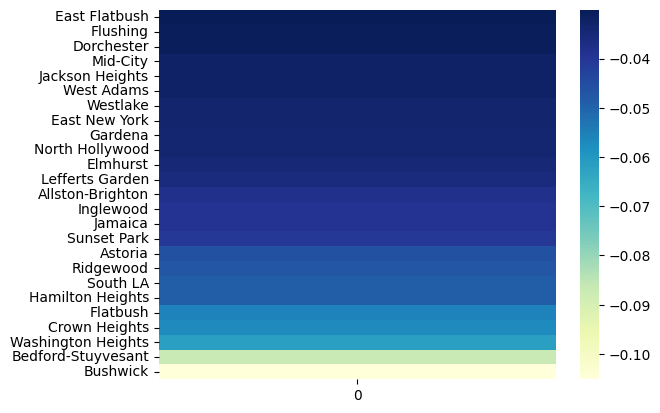

In [20]:
corrheatmap2 = sb.heatmap(pd.DataFrame(correlation).tail(25), cmap="YlGnBu") 

## City price distribution
From the below table and histogram, we can observe the following - 
1. On average, San Francisco has the most expensive homestays. This is also characterised by a higher percentage of its log_price distribution being between 5-8
2. Using similar inference, we can conclude that log_price trend in ascending order goes- Chicago, NYC, LA, Boston, DC, SF. 

In [21]:
city_prices = pd.DataFrame(columns = ["city", "mean log_price", "max log_price", "min log_price", "stddev log_price", "mean latitude", "mean longitude"])
i = 0
for city in data["city"].unique():
    dfslice = data[data["city"] == city]
    city_prices.loc[i] = [str(city), dfslice["log_price"].mean(), dfslice["log_price"].max(), dfslice["log_price"].min(), dfslice["log_price"].std(), dfslice["latitude"].mean(), dfslice["longitude"].mean()]
    i = i+1

city_prices.sort_values(by="mean log_price", axis = 0, inplace = True)
city_prices.reset_index(drop=True, inplace = True)

print(tabulate(city_prices, headers='keys', tablefmt='psql'))

+----+---------+------------------+-----------------+-----------------+--------------------+-----------------+------------------+
|    | city    |   mean log_price |   max log_price |   min log_price |   stddev log_price |   mean latitude |   mean longitude |
|----+---------+------------------+-----------------+-----------------+--------------------+-----------------+------------------|
|  0 | Chicago |          4.62008 |         7.31322 |         2.30259 |           0.700238 |         41.9082 |         -87.6644 |
|  1 | NYC     |          4.71934 |         7.6004  |         0       |           0.661567 |         40.7302 |         -73.9549 |
|  2 | LA      |          4.7205  |         7.6004  |         2.30259 |           0.739269 |         34.0565 |        -118.334  |
|  3 | Boston  |          4.88404 |         7.24423 |         2.83321 |           0.664692 |         42.3397 |         -71.0841 |
|  4 | DC      |          4.9868  |         7.6004  |         2.30259 |           0.82116 

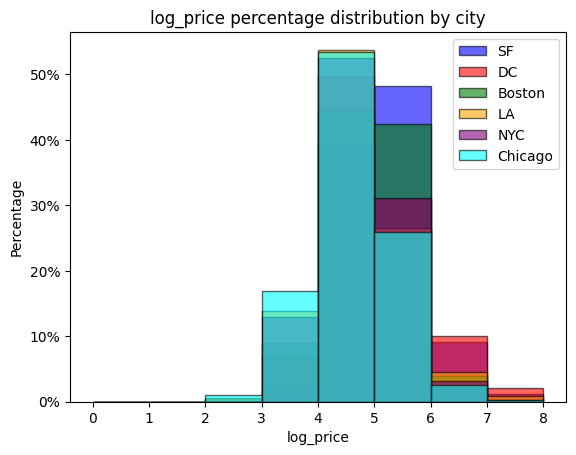

In [22]:
def format_percent(x, pos):
    return '{:.0f}%'.format(x * 100)
formatter = FuncFormatter(format_percent)
colors = ["blue", "red", "green", "orange", "purple", "cyan"]
i = 0
for city in city_prices["city"].sort_index(ascending= False):
    plt.hist(data[data["city"]==city]["log_price"], label=city,edgecolor='black', density=True, alpha=0.6, bins = [0,1,2,3,4,5,6,7,8], color = colors[i])
    plt.xlabel("log_price")
    plt.ylabel("Percentage")
    plt.title("log_price percentage distribution by city")
    i = i + 1
plt.gca().yaxis.set_major_formatter(formatter)
plt.legend(loc='upper right')
plt.show()

## City correlation heatmaps

In [24]:
# One hot encoding cities
city_list = list(pd.get_dummies(data["city"]).columns.values)
one_hot = pd.get_dummies(data["city"])
# data = data.drop("city",axis = 1)
data = pd.concat([data, one_hot], axis = 1)

In [25]:
correlation = data[city_list].corrwith(data["log_price"])
correlation = correlation.sort_values(ascending = False)

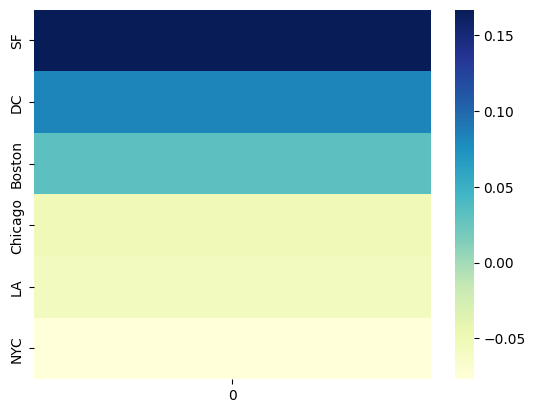

In [26]:
corrheatmap = sb.heatmap(pd.DataFrame(correlation).head(25), cmap="YlGnBu") 

# 4. Sentiment Analysis on Textual Data:
Task: Apply advanced natural language processing techniques to the `description` texts to extract
sentiment scores. Use sentiment analysis tools to determine whether positive or negative descriptions
influence listing prices, incorporating these findings into the predictive model being trained as a feature.

In [27]:
data['description'] = data['description'].replace(np.nan, '', regex=True)

# Initialize VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

def calculate_sentiment(row):
    sentence = row["description"]
    # Analyze sentiment
    sentiment_score = analyzer.polarity_scores(sentence)

    # Interpret sentiment score
    if sentiment_score['compound'] >= 0.05:
        row["sentiment"] = 1 # Positive
    elif sentiment_score['compound'] <= -0.05:
        row["sentiment"] = -1 # Negative
    else:
        row["sentiment"] = 0 # Neutral
    return row

data["sentiment"] = np.nan
data = data.apply(calculate_sentiment, axis = 1)


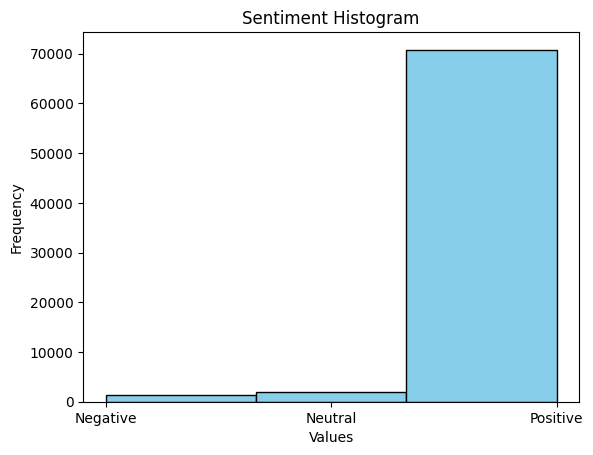

In [28]:
plt.hist(data["sentiment"], bins=3, color='skyblue', edgecolor='black')
plt.title(f"Sentiment Histogram")
plt.xticks(ticks = [-1,0,1], labels = ["Negative","Neutral","Positive"])
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.show()

Most descriptions seem to have positive sentiments associated with them.

In [29]:
print("Correlation of log_price with log_price:", data[["sentiment"]].corrwith(data["log_price"])["sentiment"])

Correlation of log_price with log_price: 0.02519701624223889


# 5. Amenities Analysis:
Task: Thoroughly parse and analyse the `amenities` provided in the listings. Identify which amenities are
most associated with higher or lower prices by applying statistical tests to determine correlations, thereby
informing both pricing strategy and model inputs.

## One-hot encoding amenities

In [30]:
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

# Creating list of all amenities
amenity_list = list()
for index, row in data.iterrows():
    amenities = row["amenities"][1:-1].split(",")
    amenities = [a.strip('\"') for a in amenities]   
    for amenity in amenities:
        if amenity not in amenity_list:
            amenity_list.append(amenity)

data[amenity_list] = 0

# One hot encoding amenities
def onehotencode_amenities(row):
    amenities = row["amenities"][1:-1].split(",")
    amenities = [a.strip('\"') for a in amenities]
    for amenity in amenities:
        row[amenity] = 1
    return row

data = data.apply(onehotencode_amenities, axis = 1)

In [31]:
correlation = data[amenity_list].corrwith(data["log_price"])
correlation = correlation.sort_values(ascending = False)

## Correlation heatmap of amenities with increasing log_price
We observe that amenities such as Family/kid friendly, TV, Cable TV etc (given below) are highly correlated with higher prices.

<Axes: >

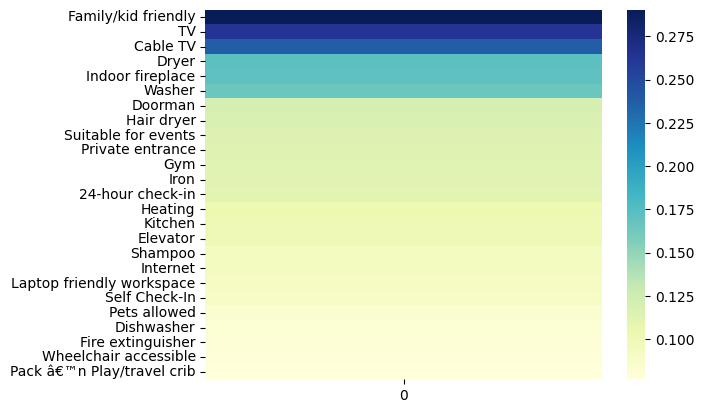

In [32]:
corrheatmap = sb.heatmap(pd.DataFrame(correlation).head(25), cmap="YlGnBu") 
corrheatmap

## Correlation heatmap of amenities with reducing log_price
We observe that amenities such as free parking on street, host greets you, Dog(s), and Smoking allowed etc (given below) are most correlated with lower prices.

<Axes: >

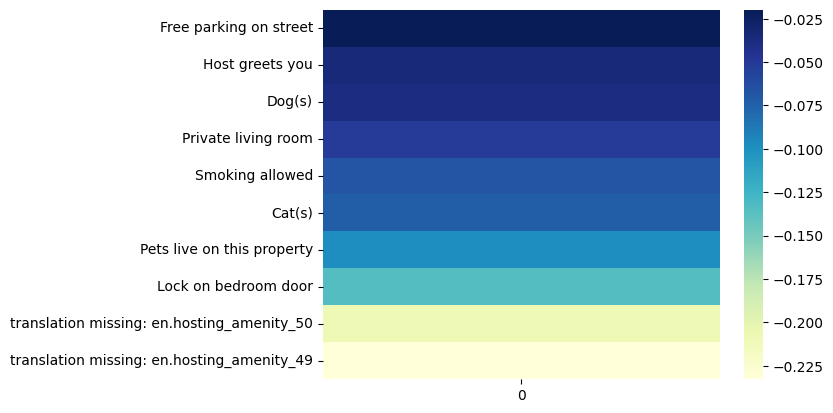

In [33]:
corrheatmap = sb.heatmap(pd.DataFrame(correlation).tail(10), cmap="YlGnBu") 
corrheatmap

In [34]:
# print(correlation.shape)
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#     print(correlation)

# 6. Categorical Data Encoding:
Task: Convert categorical data into a format suitable for machine learning analysis. Apply one-hot encoding
to variables like `room_type`, `city`, and `property_type`, ensuring that the model can interpret these as
distinct features without any ordinal implication

In [35]:
categorical_cols = ["room_type", "property_type", "bed_type"]
for col in categorical_cols:
    one_hot = pd.get_dummies(data[col])
    data = data.drop(col,axis = 1)
    data = pd.concat([data, one_hot], axis = 1)

# 7. Model Development and Training:
Task: Design and train predictive models to estimate `log_price`. Begin with a simple linear regression to
establish a baseline, then explore more complex models such as RandomForest and GradientBoosting to
better capture non-linear relationships and interactions between features. Document (briefly within
Jupyter notebook itself) the model-building process, specifying the choice of algorithms and rationale.

## Further preprocessing

In [37]:
# Dropping columns that dont relate with Y directly or have been processed to different columns
data.drop(["id", "amenities", "description", "first_review", "host_since", "last_review", "latitude", "longitude", "name", "zipcode", "thumbnail_url", "neighbourhood", "city", "Other"], axis = 1, inplace = True)
# print(list(data.columns.values))

## Dropping less important features
The features ("Days_Since_Last_Review", "Days_Since_First_Review", "host_response_rate", "review_scores_rating") have a very low correlation coefficient, along with a large number of NA values. Therefore, it is better to drop them. Each of these features had more than 15,000 NA values (see table in section 1) altogether covering 26,325 rows. Instead of dropping the rows, it is better to drop these unimportant features.

In [38]:
print("Number of rows with NaN values before dropping features: ", data.isna().any(axis=1).sum())
data.drop(["Days_Since_Last_Review", "Days_Since_First_Review", "host_response_rate", "review_scores_rating"], axis = 1, inplace = True)
print("Number of rows with NaN values after dropping features: ", data.isna().any(axis=1).sum())
# Dropping rest of rows with NA values - 
data.dropna(inplace = True)

Number of rows with NaN values before dropping features:  26325
Number of rows with NaN values after dropping features:  532


### Note
Due to access to insufficient compute and time, I chose to train on only half of the rows to train better models quicker.

In [39]:
# Dropping half the rows
half_rows = len(data) // 2
rows_to_drop = np.random.choice(data.index, size=half_rows, replace=False)
data = data.drop(rows_to_drop)

## Features with correlation outside (-0.08, 0.08)
I considered dropping features outside this correlation range. However, I decided to let the decision tree ensemble take care of it instead as it is possible for certain groups of low-correlation features to collectively highly correlate with log_price.

In [40]:
corrmatrix = data.corrwith(data["log_price"])
print(len(corrmatrix[~corrmatrix.between(-0.06, 0.06, inclusive = "neither")==True].index.values), "features have such correlation")

/opt/conda/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning:

invalid value encountered in divide

/opt/conda/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning:

invalid value encountered in divide



110 features have such correlation


## Splitting dataset

In [41]:
# Split the data into X (features) and y (target)
X = data.drop('log_price', axis=1)

# Scaled X
scaler = MinMaxScaler()
scaled_X = scaler.fit_transform(X)

y = data['log_price']

# Split the data into training and testing sets
scaled_X_train, scaled_X_test, scaled_y_train, scaled_y_test = train_test_split(scaled_X,y,test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [42]:
def compute_metric(predictions, y):
    # Calculate Mean Absolute Error (MAE)
    mae = mean_absolute_error(y, predictions)
    
    # Calculate Mean Squared Error (MSE)
    mse = mean_squared_error(y, predictions)
    
    # Calculate R-squared
    r_squared = r2_score(y, predictions)
    
    print("Mean Absolute Error:", mae)
    print("Mean Squared Error:", mse)
    print("R-squared:", r_squared)

## Linear Regression
Just testing to see baseline performance level. We observe that the model underfits greatly. Therefore, we need to use a more complex model.

In [43]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [44]:
print("Train metric")
compute_metric(model.predict(X_train), y_train)

print("Test metric")
compute_metric(model.predict(X_test), y_test)

Train metric
Mean Absolute Error: 0.29516207643258
Mean Squared Error: 0.16481103682038034
R-squared: 0.6776276531694836
Test metric
Mean Absolute Error: 35500.44046147475
Mean Squared Error: 2048806721578.3552
R-squared: -3898387408107.8594


## Decision Tree Regressor
Here we observe that the model overfits greatly. max_depth can be set. We can also use a decision tree ensemble, which can explore more possible trees and reduce overfitting. 

In [45]:
drtree = DecisionTreeRegressor()
drtree.fit(X_train, y_train)


DecisionTreeRegressor()

In [46]:
print("Train metric")
compute_metric(drtree.predict(X_train), y_train)

print("Test metric")
compute_metric(drtree.predict(X_test), y_test)

Train metric
Mean Absolute Error: 1.478687909938371e-18
Mean Squared Error: 8.308877433355316e-34
R-squared: 1.0
Test metric
Mean Absolute Error: 0.4176523166754588
Mean Squared Error: 0.33033500442729113
R-squared: 0.371451778172192


## Random Forests Regressor
After trying this decision tree ensemble, we observe that overfitting is reduced albeit still there. I tried increasing the number of estimators to reduce overfitting. I also set a lower max_depth in order to curb overfitting. However, performance stagnated at this metric.

In [47]:
random_forest = RandomForestRegressor(n_estimators = 300, max_depth = 30, n_jobs = -1)
random_forest.fit(X_train, y_train)

RandomForestRegressor(max_depth=30, n_estimators=300, n_jobs=-1)

In [48]:
print("Train metric")
compute_metric(random_forest.predict(X_train), y_train)

print("Test metric")
compute_metric(random_forest.predict(X_test), y_test)

Train metric
Mean Absolute Error: 0.12229909220004367
Mean Squared Error: 0.02676731476961798
R-squared: 0.9476428141761084
Test metric
Mean Absolute Error: 0.2993721953940795
Mean Squared Error: 0.17144969973201454
R-squared: 0.673772375148971


## Gradient Boosted Regressor
Trying more tree ensembles.

In [50]:
gradientboosted = GradientBoostingRegressor(n_estimators=100, random_state=42, max_depth = 8)
gradientboosted.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=8, random_state=42)

In [51]:
print("Train metric")
compute_metric(gradientboosted.predict(X_train), y_train)

print("Test metric")
compute_metric(gradientboosted.predict(X_test), y_test)

Train metric
Mean Absolute Error: 0.23839189919701767
Mean Squared Error: 0.09864333851533177
R-squared: 0.8070524574695702
Test metric
Mean Absolute Error: 0.2922766871157184
Mean Squared Error: 0.16285244985524802
R-squared: 0.6901308780330949


## Histogram Gradient Boosted Regressor

In [52]:
histgradientboosted = HistGradientBoostingRegressor(random_state=42)
histgradientboosted.fit(X_train, y_train)

HistGradientBoostingRegressor(random_state=42)

In [53]:
print("Train metric")
compute_metric(histgradientboosted.predict(X_train), y_train)

print("Test metric")
compute_metric(histgradientboosted.predict(X_test), y_test)

Train metric
Mean Absolute Error: 0.2716773636753337
Mean Squared Error: 0.1359305286787893
R-squared: 0.7341182703446512
Test metric
Mean Absolute Error: 0.2903028189454043
Mean Squared Error: 0.15927495058282626
R-squared: 0.6969380004274336


## XGBoosted Decision Tree Regressor
This model gave promising train set scores, similar to that of Random Forests. This led me to try out XGBoosted Random Forests.

In [54]:
# Define XGBoost model parameters
params = {
    'objective': 'reg:squarederror',  # Use squared error for regression task
    'max_depth': 15,                    # Maximum depth of each tree
    'learning_rate': 0.1,              # Learning rate (eta) for boosting
    'n_estimators': 100               # Number of boosting rounds (trees)
}

# Initialize XGBoost regressor
xgb_regressor = xgb.XGBRegressor(**params)

# Train the model on the training data
xgb_regressor.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=15, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [55]:
print("Train metric")
compute_metric(xgb_regressor.predict(X_train), y_train)

print("Test metric")
compute_metric(xgb_regressor.predict(X_test), y_test)

Train metric
Mean Absolute Error: 0.1047222440068378
Mean Squared Error: 0.022541351175732166
R-squared: 0.955908849192113
Test metric
Mean Absolute Error: 0.2978324478772469
Mean Squared Error: 0.171093021342166
R-squared: 0.6744510485099501


## XGBoosted Random Forests Regressor

In [59]:
rf_reg = random_forest
gb_reg = xgb_regressor

rf_pred = rf_reg.predict(X_train)
gb_pred = gb_reg.predict(X_train)
combined_pred_reg = (rf_pred + gb_pred) / 2

rf_pred_test = rf_reg.predict(X_test)
gb_pred_test = gb_reg.predict(X_test)
combined_pred_reg_test = (rf_pred_test + gb_pred_test) / 2

In [60]:
print("Train metric")
compute_metric(combined_pred_reg, y_train)
print("Test metric")
compute_metric(combined_pred_reg_test, y_test)

Train metric
Mean Absolute Error: 0.11216002160949853
Mean Squared Error: 0.02254172681672336
R-squared: 0.9559081144338697
Test metric
Mean Absolute Error: 0.2948080267496345
Mean Squared Error: 0.1674012812775007
R-squared: 0.681475543710266


# 8. Model Optimization and Validation:
Task: Systematically optimize the models to achieve the best performance. Employ techniques like grid
search to experiment with different hyperparameters settings. Validate model choices through techniques
like k-fold cross-validation, ensuring the model generalizes well to unseen data.

### Note
Due to insufficient compute and time, the number of iterations for random search had to be set to a lower number (10 to 25) instead of an ideally higher number (such as 100), resulting in lesser models being explored by random search. Therefore accuracies found are relatively lower than they could have been.

In [61]:
kf = KFold(n_splits=3, shuffle=True, random_state=42)
scorer = make_scorer(r2_score)

In [66]:
param_dist_rf = {
    'n_estimators': randint(20, 1000),
    'max_depth': randint(5, 100),
    'min_samples_split': randint(1, 4),
    'min_samples_leaf': randint(1, 10),
}

rf = RandomForestRegressor(random_state=42, max_features = "sqrt", n_jobs = -1)

random_search_rf = RandomizedSearchCV(estimator=rf, param_distributions=param_dist_rf, n_iter=25, cv=kf, scoring=scorer, random_state=42)
random_search_rf.fit(X_train, y_train)

best_params_rf = random_search_rf.best_params_
best_score_rf = random_search_rf.best_score_

print("Random Forest Best Parameters:", best_params_rf)
print("Random Forest Best R2 Score:", best_score_rf)

/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning:


30 fits failed out of a total of 75.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py", line 340, in fit
    self._validate_params()
  File "/opt/conda/lib/python3.10/site-packages/sklearn/base.py", line 600, in _validate_params
    validate_parameter_constraints(
  File "/opt/conda/lib/python3.10/site-packages/sklearn/util

Random Forest Best Parameters: {'max_depth': 93, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 78}
Random Forest Best R2 Score: 0.6327322384914927


In [83]:
param_dist_gb = {
    'n_estimators': randint(20, 1000),
    'max_depth': randint(5, 100),
    'min_samples_split': randint(1, 4),
    'min_samples_leaf': randint(1, 10),
    'max_features': ['sqrt'],
}

gb = GradientBoostingRegressor(random_state=42)

random_search_gb = RandomizedSearchCV(estimator=gb, param_distributions=param_dist_gb, n_iter=10, cv=kf, scoring=scorer, random_state=42)
random_search_gb.fit(X_train, y_train)

best_params_gb = random_search_gb.best_params_
best_score_gb = random_search_gb.best_score_

print("Gradient Boosting Best Parameters:", best_params_gb)
print("Gradient Boosting Best R2 Score:", best_score_gb)

/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning:


12 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
12 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_gb.py", line 420, in fit
    self._validate_params()
  File "/opt/conda/lib/python3.10/site-packages/sklearn/base.py", line 600, in _validate_params
    validate_parameter_constraints(
  File "/opt/conda/lib/python3.10/site-packages/sklearn/utils/_p

Gradient Boosting Best Parameters: {'max_depth': 87, 'max_features': 'sqrt', 'min_samples_leaf': 7, 'min_samples_split': 3, 'n_estimators': 478}
Gradient Boosting Best R2 Score: 0.6874376420801825


In [64]:
param_dist_xgb = {
    'n_estimators': randint(20, 1000),
    'learning_rate': uniform(0.01, 0.3),
    'max_depth': randint(5, 100),
    'subsample': uniform(0.5, 1),
    'colsample_bytree': uniform(0.5, 1),
}

xgb = XGBRegressor(random_state=42, n_jobs = -1)

random_search_xgb = RandomizedSearchCV(estimator=xgb, param_distributions=param_dist_xgb, n_iter=10, cv=kf, scoring=scorer, random_state=42)
random_search_xgb.fit(X_train, y_train)

best_params_xgb = random_search_xgb.best_params_
best_score_xgb = random_search_xgb.best_score_

print("XGBoost Best Parameters:", best_params_xgb)
print("XGBoost Best R2 Score:", best_score_xgb)


/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning:


21 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.10/site-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py", line 1090, in fit
    self._Booster = train(
  File "/opt/conda/lib/python3.10/site-packages/xgboost/core.py", line 730, in inner_f
  

XGBoost Best Parameters: {'colsample_bytree': 0.8998609717152555, 'learning_rate': 0.023999698964084628, 'max_depth': 64, 'n_estimators': 995, 'subsample': 0.7327713404303042}
XGBoost Best R2 Score: 0.6742919531038826


In [67]:
param_dist_hgb = {
    'learning_rate': uniform(0.01, 0.3),
    'max_iter': randint(100, 500),
    'max_depth': randint(5, 100),
    'min_samples_leaf': randint(1, 10),
    'l2_regularization': uniform(0.0, 1.0)
}

hgb = HistGradientBoostingRegressor(random_state=42)

random_search_hgb = RandomizedSearchCV(estimator=hgb, param_distributions=param_dist_hgb, n_iter=30, cv=kf, scoring=scorer, random_state=42, n_jobs = -1)
random_search_hgb.fit(X_train, y_train)

best_params_hgb = random_search_hgb.best_params_
best_score_hgb = random_search_hgb.best_score_

print("HistGradientBoost Best Parameters:", best_params_hgb)
print("HistGradientBoost Best R2 Score:", best_score_hgb)

HistGradientBoost Best Parameters: {'l2_regularization': 0.388677289689482, 'learning_rate': 0.09140470953216877, 'max_depth': 57, 'max_iter': 379, 'min_samples_leaf': 9}
HistGradientBoost Best R2 Score: 0.6955645737957772


## Final model (best R2 score out of all manually tuned and randomly searched models)
XGBoosted Random Forests Regressor

In [80]:
# XGBoosted Random Forests Regressor

random_forest = RandomForestRegressor(n_estimators = 300, max_depth = 30, n_jobs = -1)
random_forest.fit(X_train, y_train)

params = {
    'objective': 'reg:squarederror',  # Use squared error for regression task
    'max_depth': 15,                    # Maximum depth of each tree
    'learning_rate': 0.1,              # Learning rate (eta) for boosting
    'n_estimators': 100               # Number of boosting rounds (trees)
}
xgb_regressor = xgb.XGBRegressor(**params)
xgb_regressor.fit(X_train, y_train)

rf_reg = random_forest
gb_reg = xgb_regressor

rf_pred = rf_reg.predict(X_train)
gb_pred = gb_reg.predict(X_train)
combined_pred_reg = (rf_pred + gb_pred) / 2

print("Train metric")
compute_metric(combined_pred_reg, y_train)

Train metric
Mean Absolute Error: 0.11216002160949853
Mean Squared Error: 0.02254172681672336
R-squared: 0.9559081144338697


In [71]:
print("Train metric")
compute_metric(xgb_regressor.predict(X_train), y_train)

Train metric
Mean Absolute Error: 0.1047222440068378
Mean Squared Error: 0.022541351175732166
R-squared: 0.955908849192113


# 9. Feature Importance and Model Insights:
Task: Analyze the trained models to identify which features most significantly impact `log_price`. Utilize
model-specific methods like feature importance scores for tree-based models and SHAP values for an in-
depth understanding of feature contributions.

## Random Forest Feature Importances

From the graphs below, we can observe that- Entire home/apt, bathrooms, city_centre_distance, Host Tenure, number of reviews, accommodates, bedrooms, amenities count, LA, DC are judged to be the most valuable features relating to log_price.

In [72]:
feature_importances = random_forest.feature_importances_
feature_names = X_train.columns 

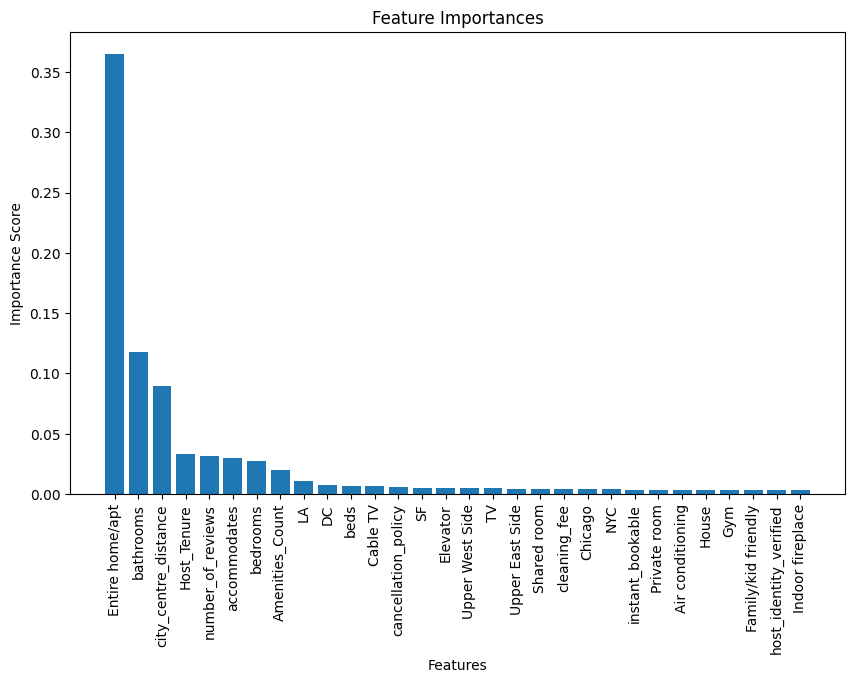

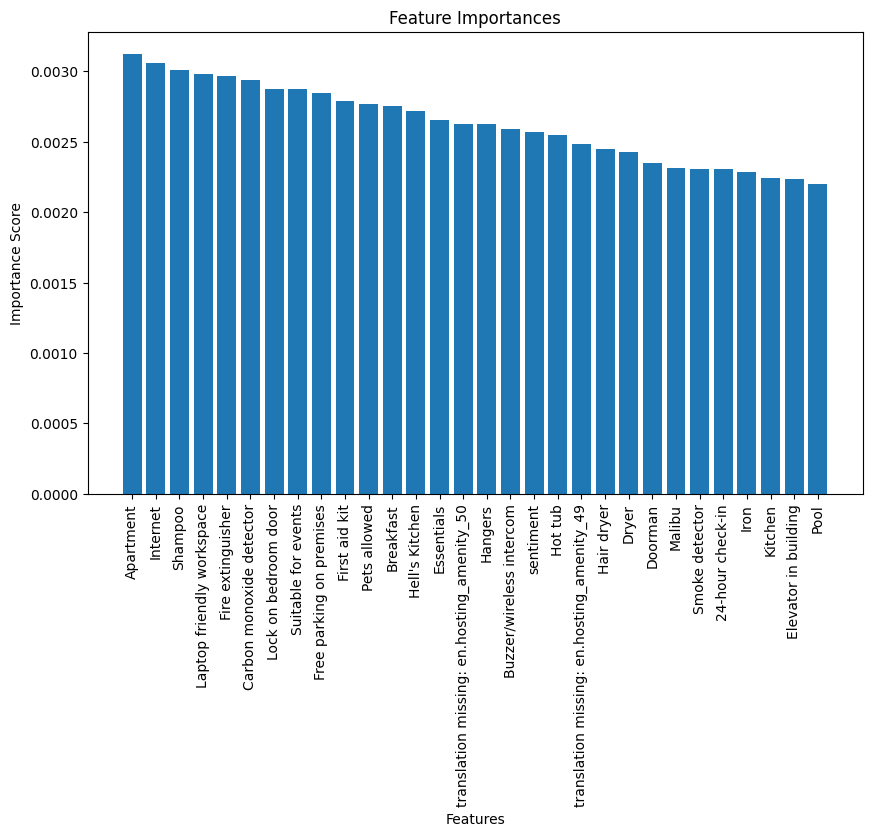

In [74]:
def show_feature_importances(feature_importances, groupsize = 30, grouplimit = 2):
    for i in range(0, (len(feature_importances)//groupsize) -1):
        if i>=grouplimit:
            break
        # Sort feature importances in descending order
        sorted_indices = feature_importances.argsort()[::-1]
        sorted_feature_importances = feature_importances[sorted_indices][i*groupsize:(i+1)*groupsize]
        sorted_feature_names = feature_names[sorted_indices][i*groupsize:(i+1)*groupsize]
        
        # Plot feature importances
        plt.figure(figsize=(10, 6))
        plt.bar(range(groupsize), sorted_feature_importances, tick_label=sorted_feature_names)
        plt.title("Feature Importances")
        plt.xlabel("Features")
        plt.ylabel("Importance Score")
        plt.xticks(rotation=90)
        plt.show()

    return sorted_feature_names, sorted_feature_importances

sorted_feature_names, sorted_feature_importances = show_feature_importances(random_forest.feature_importances_)

## SHAP Feature Importances
The following conclusions can be made from the below graph - 
1. Lower city centre distance implies higher price
2. Homestays in East Harlem and Upper West Side are expensive
3. Higher amenities count implies higher price
4. Homestays in San Francisco are highly priced
5. Higher accomodates implies higher price
6. More bedrooms implies higher price


In [78]:
xgb_regressor_explained = shap.Explainer(xgb_regressor, X_train.astype('float64'))
xgb_regressor_shap_values = xgb_regressor_explained.shap_values(np.array(X_train), approximate = True, check_additivity = False)

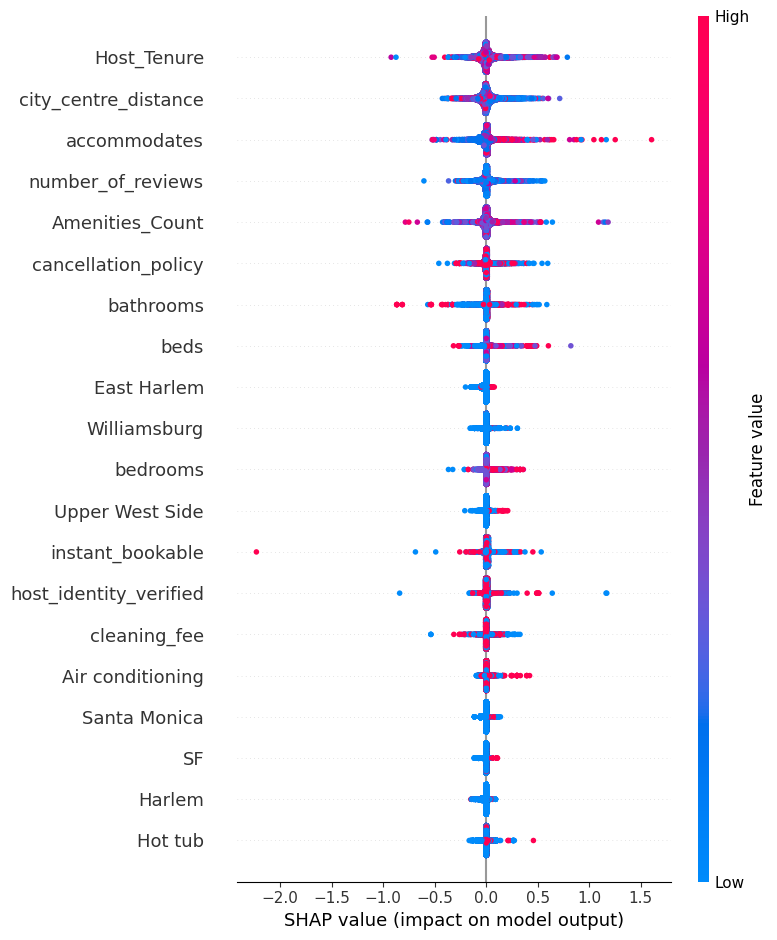

In [79]:
shap.summary_plot(xgb_regressor_shap_values, X_train)

# 10. Predictive Performance Assessment:
Task: Critically evaluate the performance of the final model on a reserved test set. Use metrics such as
Root Mean Squared Error (RMSE) and R-squared to assess accuracy and goodness of fit. Provide a detailed
analysis of the residuals to check for any patterns that might suggest model biases or misfit.

Final model: XGBoosted Random Forests Regressor

In [82]:
# Evaluating on train
print("Train metrics:")
rf_pred = rf_reg.predict(X_train)
gb_pred = gb_reg.predict(X_train)
combined_pred_reg = (rf_pred + gb_pred) / 2
compute_metric(combined_pred_reg, y_train)
# Evaluating on test
print("\nTest metrics:")
rf_pred_test = rf_reg.predict(X_test)
gb_pred_test = gb_reg.predict(X_test)
combined_pred_reg_test = (rf_pred_test + gb_pred_test) / 2
compute_metric(combined_pred_reg_test, y_test)

Train metrics:
Mean Absolute Error: 0.11216002160949853
Mean Squared Error: 0.02254172681672336
R-squared: 0.9559081144338697

Test metrics:
Mean Absolute Error: 0.2948080267496345
Mean Squared Error: 0.1674012812775007
R-squared: 0.681475543710266
